In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from datasets import DatasetDict

ds_path = "/mnt/ceph/users/sgolkar/datasets/astroclip/spec_chunked_ds"
ds = DatasetDict.load_from_disk(ds_path)

In [3]:
from fillm.run.model import *

def load_model_from_ckpt(ckpt_path: str):
    """
    Load a model from a checkpoint.
    """
    if Path(ckpt_path).is_dir():
        ckpt_path = Path(ckpt_path) / "ckpt.pt"

    chkpt = torch.load(ckpt_path)
    config = chkpt["config"]
    state_dict = chkpt["model"]
    model_name = config["model"]['kind']
    model_keys = get_model_keys(model_name)
    # config['log_encoding']=False
    # config['log_decoding']=False
    # config['only_pred_masked']=True
    # config['first_layer_norm']=True
    # config['mlp_layer_norm']=True
    
    model_args = {k: config['model'][k] for k in model_keys}

    model_ctr, config_cls = model_registry[model_name]
    model_config = config_cls(**model_args)
    model = model_ctr(model_config)
    model.load_state_dict(state_dict)

    return {"model": model, "config": config}

model_path = "/mnt/home/sgolkar/ceph/saves/fillm/run-seqformer-2708117"
out = load_model_from_ckpt(model_path)

config = out['config']
model = out['model'].cpu()
model.eval()

print(model)


Seqformer(
  (data_embed): Linear(in_features=22, out_features=768, bias=True)
  (position_embed): Embedding(800, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (layernorm1): LayerNorm()
      (attention): SelfAttention(
        (attention): Linear(in_features=768, out_features=2304, bias=True)
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
        (residual_dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm2): LayerNorm()
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (encoder): Linear(in_features=768, out_features=3072, bias=True)
        (decoder): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (final_layernorm): LayerNorm()
  (head): Linear(in_features=768, out_features=22, bias=True)
)


In [4]:
from fillm.run.processing import seq_collator_with_chunkedmasking

collator = seq_collator_with_chunkedmasking(num_chunks = config['dataset']['num_chunks'], chunk_width=config['dataset']['chunk_width'])

2023-09-28 12:46:14.641134: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 12:46:15.052861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 12:46:18.118694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


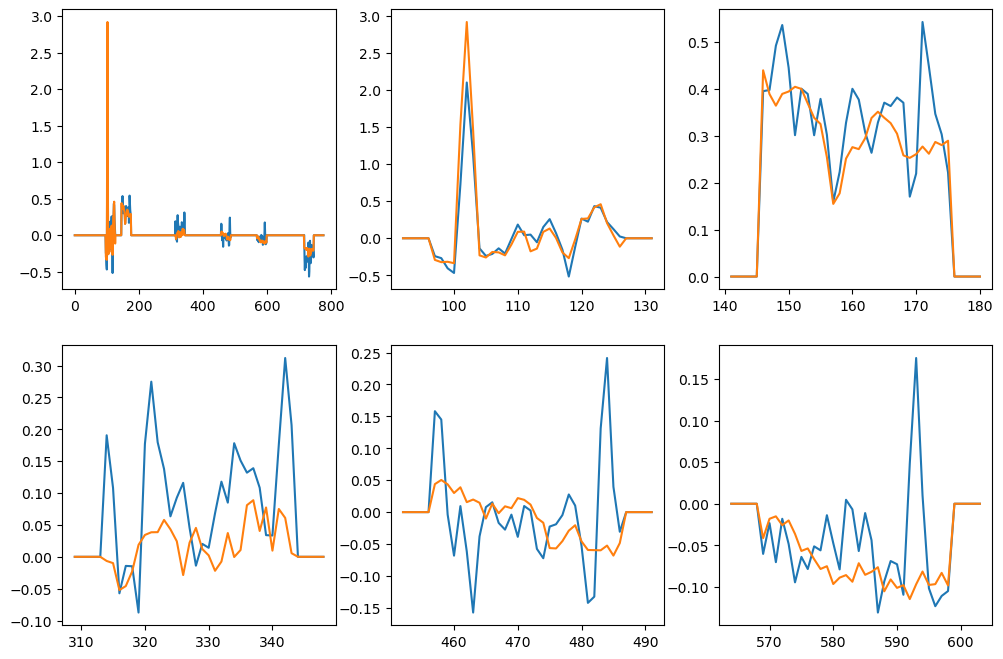

In [5]:
# set pytorch seed
torch.manual_seed(0)

# start a 2x3 figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# flatten the axs array
axs = axs.flatten()

sample = collator([ds['test'][1]])

x,y = sample['x'].squeeze(), sample['y'].squeeze()

pred = model(**sample)['preds'].squeeze()


input_ = x[1:,2:].mean(1)
target_ = y[1:,2:].mean(1)
pred_ = pred[1:,2:].data.mean(1)
loc = np.float32(input_!= target_)

axs[0].plot(target_*loc)
axs[0].plot(pred_*loc)
# plt.show()

start = loc.argmax()
for i in range(5):

    axs[i+1].plot(range(start-5,start+35), (target_*loc)[start-5:start+35])
    axs[i+1].plot(range(start-5,start+35), (pred_*loc)[start-5:start+35])
    start = start+30 + loc[start+30:].argmax()
    # plt.show()

Override the forward of the model to get all the intermediate embeddings

In [6]:
    import torch.nn.functional as F
    
    def forward(
        self, x: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        device = x.device
        t = x.shape[1]

        # find the mask locations
        locs = x != y

        if t > self.config.block_size:
            raise ValueError(
                f"Cannot forward sequence of length {t}, "
                f"block size is only {self.config.block_size}"
            )
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        # forward the GPT model itself
        data_emb = self.data_embed(x)  # to shape (b, t, embedding_dim)
        pos_emb = self.position_embed(pos)  # to shape (t, embedding_dim)

        x = self.dropout(data_emb + pos_emb)
        embeddings = []
        for block in self.blocks:
            x = block(x)
            embeddings.append(x.detach().clone())
        x = self.final_layernorm(x)

        preds = self.head(x)
        if y is not None:
            # if we are given some desired targets also calculate the loss
            locs = locs.type_as(preds)
            loss = F.mse_loss(preds * locs, y * locs, reduction="mean") / locs.mean()
        else:
            loss = None

        return {"preds": preds, "loss": loss, "embeddings": embeddings}

    model.forward = forward.__get__(model, type(model))

In [7]:
class seq_decoder(nn.Module):

    def __init__(self, num_layers=6, embed_dim=128, nhead=4, model_embed_dim=768):
        super().__init__()

        self.num_layers = num_layers

        self.queries = nn.ParameterList([nn.Parameter(torch.randn(1, 1, embed_dim)) for i in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(embed_dim=embed_dim, num_heads=nhead, batch_first=True, kdim=model_embed_dim, vdim=model_embed_dim) for _ in range(num_layers)])
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, model, sample):

        embeddings = model(**sample)['embeddings'][-self.num_layers:]
        batch_size = len(sample['x'])

        out = 0

        for query,attention,embedding in zip(self.queries, self.attentions, embeddings):
            
            out += attention(query=query.repeat(batch_size,1,1), key=embedding, value=embedding, need_weights=False)[0]

        return self.layernorm(out).squeeze()


my_decoder = seq_decoder()      

num_params = sum(p.numel() for p in my_decoder.parameters())
print(f"{num_params:,}")

1,380,352


In [8]:
def no_mask_collator(batch):
    x = torch.tensor([b['x'] for b in batch])
    return {'x':x}

sample = no_mask_collator([ds['test'][i] for i in range(8)])
my_decoder(model=model, sample=sample).shape

torch.Size([8, 128])

In [9]:
my_decoder

seq_decoder(
  (queries): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x1x128]
      (1): Parameter containing: [torch.float32 of size 1x1x128]
      (2): Parameter containing: [torch.float32 of size 1x1x128]
      (3): Parameter containing: [torch.float32 of size 1x1x128]
      (4): Parameter containing: [torch.float32 of size 1x1x128]
      (5): Parameter containing: [torch.float32 of size 1x1x128]
  )
  (attentions): ModuleList(
    (0-5): 6 x MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

In [10]:
class RedshiftPredictor(nn.Module):
    """ Tries to predict the redshift from the 
    pre-trained transformer model
    """
    
    def __init__(self, model,  decoder):
        super(RedshiftPredictor, self).__init__()
        self.model = model
        
        # But let's freeze the pretrained model
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.decoder = decoder
        self.projection = nn.Linear(128, 1)
    
    def forward(self, x):
        
        # Feeding all of that to our transformer model
        x  = self.decoder(sample=x, model=self.model)
        
        # Using the class token to form a prediction for redshift with a linear
        # head
        x = self.projection(x)
        
        return x.squeeze()

In [11]:
predictor = RedshiftPredictor(model, my_decoder)
predictor = predictor.to('cuda')

In [12]:
from torch.utils.data.dataset import ConcatDataset
from datasets import load_dataset

In [13]:
ds_path = "/mnt/ceph/users/sgolkar/datasets/astroclip/spec_chunked_ds"
ds = DatasetDict.load_from_disk(ds_path)
ds.set_format(type='torch')

dataset = load_dataset('../../astroclip/datasets/legacy_survey.py', 
                       cache_dir='/mnt/home/flanusse/ceph/huggingface/datasets',
                      )
dataset.set_format(type='torch', columns=['redshift'])

In [14]:
dataloader1 = torch.utils.data.DataLoader(ds['train'], 
                                         batch_size=64, 
                                         num_workers=10,
                                         shuffle=False, pin_memory=True)

dataloader2 = torch.utils.data.DataLoader(dataset['train'], 
                                         batch_size=64, 
                                         num_workers=10,
                                         shuffle=False, pin_memory=True)

In [23]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 1e-5
epochs = 5

criterion = nn.MSELoss().to('cuda')
optimizer = optim.AdamW(predictor.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

losses = []
predictor.train()

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, (data1, data2) in enumerate(zip(dataloader1, dataloader2), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = {'x': data1['x'].to('cuda')}
        labels = data2['redshift'].to('cuda')
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = predictor(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print
        if i % 10 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
            
    scheduler.step()

[1,     1] loss: 0.008
[1,    11] loss: 0.007
[1,    21] loss: 0.007
[1,    31] loss: 0.006
[1,    41] loss: 0.008
[1,    51] loss: 0.007
[1,    61] loss: 0.008
[1,    71] loss: 0.007
[1,    81] loss: 0.005
[1,    91] loss: 0.006
[1,   101] loss: 0.005
[1,   111] loss: 0.005
[1,   121] loss: 0.005
[1,   131] loss: 0.006
[1,   141] loss: 0.007
[1,   151] loss: 0.006
[1,   161] loss: 0.018
[1,   171] loss: 0.005
[1,   181] loss: 0.006
[1,   191] loss: 0.007
[1,   201] loss: 0.005
[1,   211] loss: 0.006
[1,   221] loss: 0.005
[1,   231] loss: 0.005
[1,   241] loss: 0.006
[1,   251] loss: 0.006
[1,   261] loss: 0.009
[1,   271] loss: 0.007
[1,   281] loss: 0.005
[1,   291] loss: 0.006
[1,   301] loss: 0.007
[1,   311] loss: 0.005
[1,   321] loss: 0.007
[1,   331] loss: 0.006
[1,   341] loss: 0.007
[1,   351] loss: 0.005
[1,   361] loss: 0.006
[1,   371] loss: 0.011
[1,   381] loss: 0.010
[1,   391] loss: 0.008
[1,   401] loss: 0.009
[1,   411] loss: 0.007
[1,   421] loss: 0.007
[1,   431] 

KeyboardInterrupt: 

In [17]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/mnt/sw/nix/store/0lj7r9gvs74j1rz053whdal23yizianw-python-3.10.8-view/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


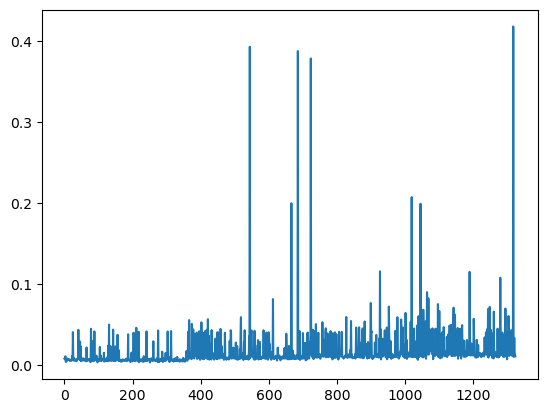

In [24]:
plot(losses)

(0.0, 1.0)

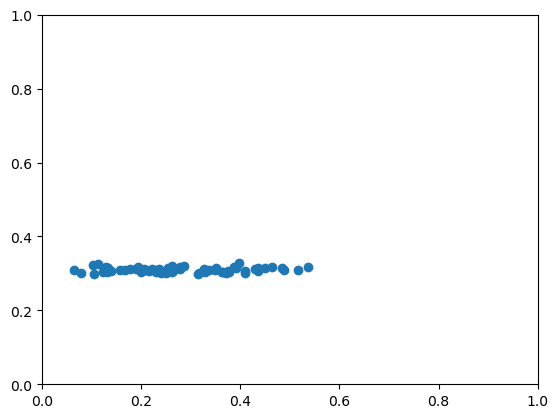

In [25]:
scatter((labels.cpu().detach().numpy()), 
        (predictor(inputs).cpu().detach().numpy()))
xlim(0,1)
ylim(0,1)

In [26]:
labels

tensor([0.2498, 0.5155, 0.1285, 0.1777, 0.2513, 0.1899, 0.3975, 0.4101, 0.2650,
        0.1584, 0.4852, 0.3270, 0.4093, 0.1399, 0.1989, 0.4888, 0.2066, 0.3177,
        0.3508, 0.1680, 0.0645, 0.3288, 0.3633, 0.2631, 0.1030, 0.2216, 0.3871,
        0.2360, 0.3718, 0.2283, 0.4363, 0.3749, 0.3482, 0.0790, 0.2540, 0.4636,
        0.1230, 0.1259, 0.2856, 0.1329, 0.1945, 0.2292, 0.3144, 0.2400, 0.3362,
        0.2548, 0.1050, 0.4503, 0.3910, 0.2616, 0.3775, 0.2062, 0.4364, 0.2156,
        0.2792, 0.1137, 0.1331, 0.5369, 0.3638, 0.1315, 0.2105, 0.1302, 0.2794,
        0.4297], device='cuda:0')